In [4]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D




In [5]:
%matplotlib notebook

# Set color schemes by visual area

In [6]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Set dataset parameters

In [7]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
#data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
DATA ID: traces001|fit-2dgaus_dff-no-cutoff-thr-0.50


In [56]:


data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])


filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)


traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats


# Load data

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [80]:
reload(rfutils)
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.pyc'>

In [82]:

scale_sigma = True
reliable_only = True


#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    vdf = g[g['experiment']==expname]
    rdf_list.append(vdf)
df = pd.concat(rdf_list)

#### Filter for good fits only
df = df[df['r2']>fit_thr]
df.groupby(['visual_area']).count()
    
#### Split fx, fy for theta comp
fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy



Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [83]:
# df.groupby(['visual_area', 'datakey']).count()
df.groupby(['visual_area', 'experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  \
visual_area experiment                                                         
Li          rfs10       405     405     405    405  405  405       405   405   
Lm          rfs10       170     170     170    170  170  170       170   170   
V1          rfs         540     540     540    540  540  540       540   540   

                        datakey  fovnum  session  std_x  std_y  fwhm_avg  \
visual_area experiment                                                     
Li          rfs10           405     405      405    405    405       405   
Lm          rfs10           170     170      170    170    170       170   
V1          rfs             540     540      540    540    540       540   

                        std_avg  area  datakey_ix   fx   fy  
visual_area experiment                                       
Li          rfs10           405   405         405  405  405  
Lm          rfs10           170   170         170  170  170  
V1          rfs             540   540         540  540  540

In [34]:
# df.groupby(['visual_area', 'datakey']).count()
df.groupby(['visual_area', 'experiment']).count()

r2  sigma_x  sigma_y  theta   x0   y0  animalid  \
visual_area experiment                                                     
Li          rfs10       404      404      404    404  404  404       404   
Lm          rfs10       187      187      187    187  187  187       187   
V1          rfs         544      544      544    544  544  544       544   

                        cell  datakey  fovnum  session  avg_size  datakey_ix  \
visual_area experiment                                                         
Li          rfs10        404      404     404      404       404         404   
Lm          rfs10        187      187     187      187       187         187   
V1          rfs          544      544     544      544       544         544   

                         fx   fy  
visual_area experiment            
Li          rfs10       404  404  
Lm          rfs10       187  187  
V1          rfs         544  544

# Set output dir

In [84]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s_2' %filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2


## Check size of RFs by x/y

In [85]:
# fx = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.cos(df['theta']))
# fy = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.sin(df['theta']))

# df['fx'] = fx
# df['fy'] = fy

# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis
# 

In [86]:
df.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
22  0.585001  46.670332  36.780253  2.939559 -29.065480 -11.080597    JC089   
23  0.696801  45.149795  27.452993  0.127034  13.248381 -21.937449    JC089   
24  0.876773  28.931146  20.644447  2.964704  24.519398   2.811875    JC089   
25  0.767423  31.775266  30.710669  0.442568   3.718242  11.808561    JC089   
26  0.515310  38.655484  25.170942  0.701064   8.476630   2.498789    JC089   

    cell              datakey experiment    ...       session visual_area  \
22    71  20190522_JC089_fov1      rfs10    ...      20190522          Li   
23    89  20190522_JC089_fov1      rfs10    ...      20190522          Li   
24    99  20190522_JC089_fov1      rfs10    ...      20190522          Li   
25   116  20190522_JC089_fov1      rfs10    ...      20190522          Li   
26   145  20190522_JC089_fov1      rfs10    ...      20190522          Li   

        std_x      std_y   fwhm_avg    std_avg        area  datakey_ix  \
22  19.859716  15.651172  41.725293  17.755444  976.494391           1   
23  19.212679  11.682125  36.301394  15.447402  705.114482           1   
24  12.311126   8.784871  24.787797  10.547999  339.768444           1   
25  13.521390  13.068370  31.242968  13.294880  555.127346           1   
26  16.449142  10.711039  31.913213  13.580091  553.509058           1   

           fx         fy  
22  19.455779   3.985095  
23  19.057864   2.434098  
24  12.119023   2.166355  
25  12.218671   5.790689  
26  12.569713  10.610211  

[5 rows x 21 columns]

In [87]:
df.groupby(['visual_area']).mean()['std_avg']

visual_area
Li    13.166591
Lm    11.097451
V1     8.970108
Name: std_avg, dtype: float64

In [37]:
df.groupby(['visual_area', 'experiment']).count()

r2  sigma_x  sigma_y  theta   x0   y0  animalid  \
visual_area experiment                                                     
Li          rfs10       386      386      386    386  386  386       386   
Lm          rfs10       151      151      151    151  151  151       151   
V1          rfs         495      495      495    495  495  495       495   

                        cell  datakey  session  avg_size  datakey_ix   fx   fy  
visual_area experiment                                                          
Li          rfs10        386      386      386       386         386  386  386  
Lm          rfs10        151      151      151       151         151  151  151  
V1          rfs          495      495      495       495         495  495  495

#### Get x + y components of vector spanned by ellipse (major)

In [73]:
datakey = '20190622_JC085_fov1'
rid=25

params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
df[(df['datakey']==datakey) & (df['cell']==rid)][params]

Empty DataFrame
Columns: [r2, sigma_x, sigma_y, theta, x0, y0, datakey, cell, experiment, avg_size, fx, fy]
Index: []

90


<IPython.core.display.Javascript object>


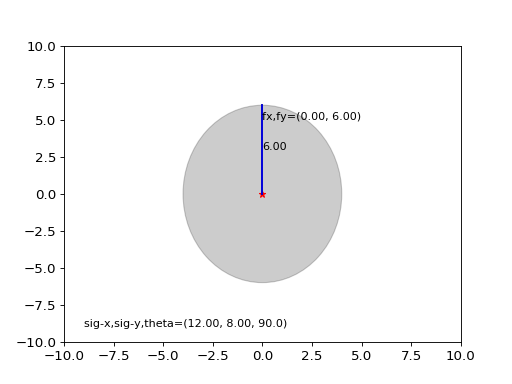

(0.0, 6.0)


NameError: name 'rid' is not defined

In [102]:
from matplotlib.patches import Ellipse
# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis


x0, y0 = (0, 0)
M = 12 #10
m = 8 #3
theta = 90 #np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

In [72]:
print(scale_sigma)

True


<IPython.core.display.Javascript object>


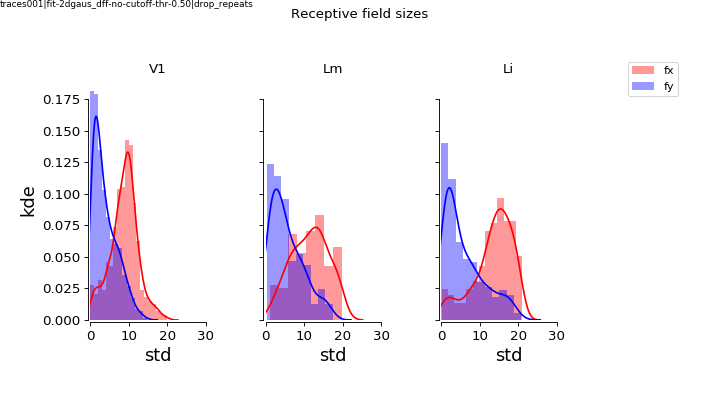

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'split_fxy_std_drop_repeats')


In [117]:
split_components = True
scale_sigma = False
curr_metric = 'std'

xlim = 25 if curr_metric=='std' else 60.

x_color = 'r'
y_color = 'b'
#experiment = 'rfs'

#_df = df[df['experiment']==experiment].copy()

#sigma_str = 'fwhm' if scale_sigma else 'sigma'
if split_components:
    xlim=35
else:
    xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else '%s_' % curr_metric

offset=0
fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    g = df[df['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    
    ax.set_xlim([0, xlim])

    ax.set_xlabel(curr_metric)


sns.despine(trim=True, offset=2)
    
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.2)
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('Receptive field sizes')

figname = 'split_%sxy_%s_%s' % (sz_metric, curr_metric, filter_by)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

In [118]:
fieldnames = ['x0', 'y0', 'theta', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(fieldnames)

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


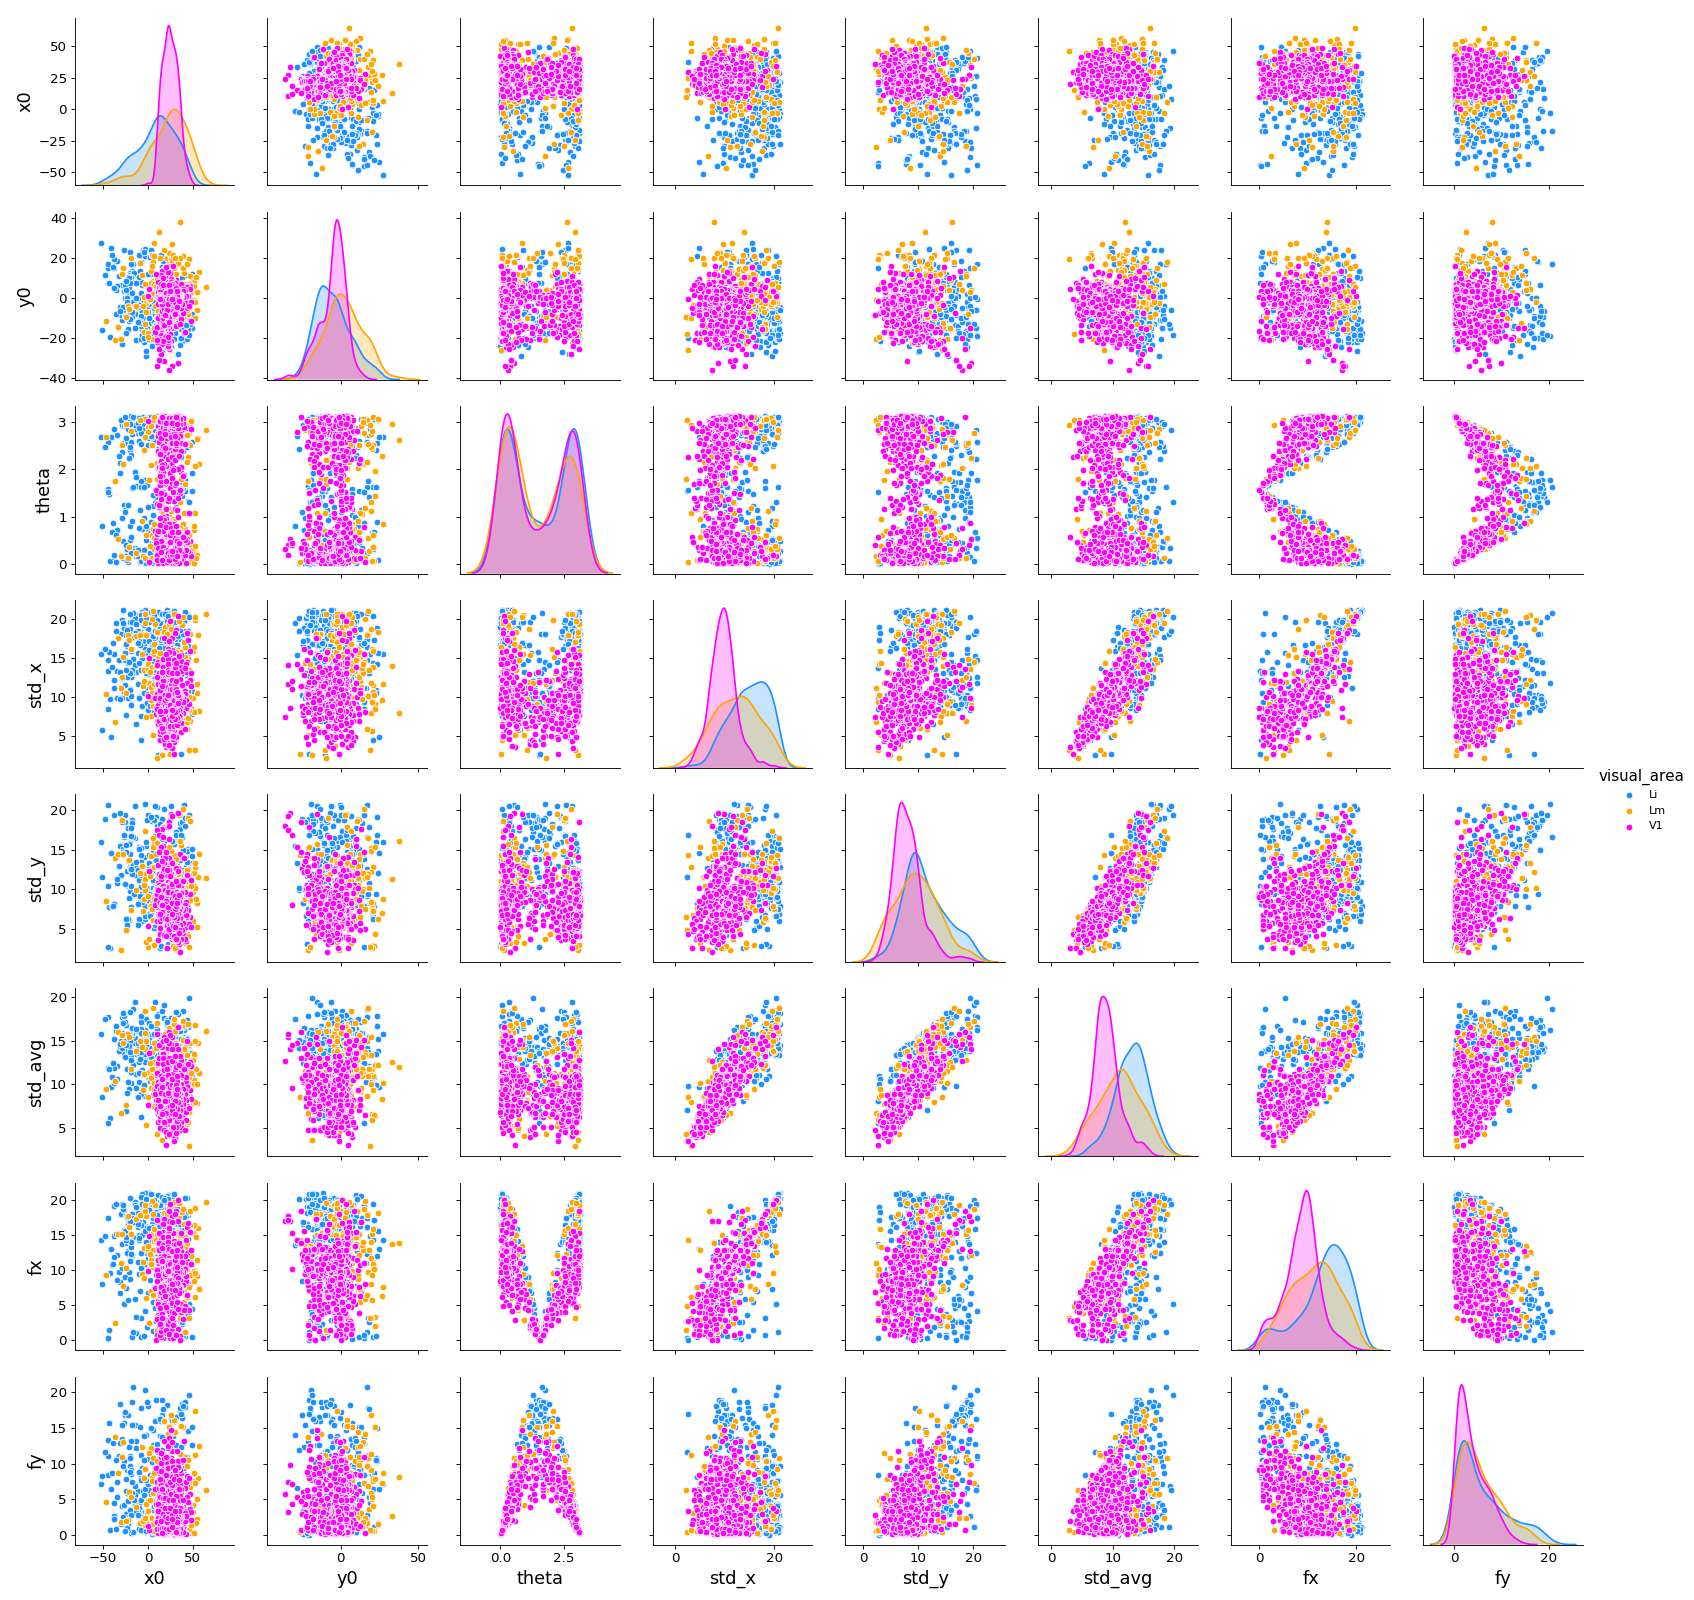

In [119]:
# theta = 90 is vertically-long, 0 = horizontal

sns.pairplot(df[fieldnames], hue='visual_area', palette=area_colors)
pl.savefig(os.path.join(genstats_dir, 'pairplot_all_params_%s_%s.png' % (curr_metric, filter_by)))


<IPython.core.display.Javascript object>


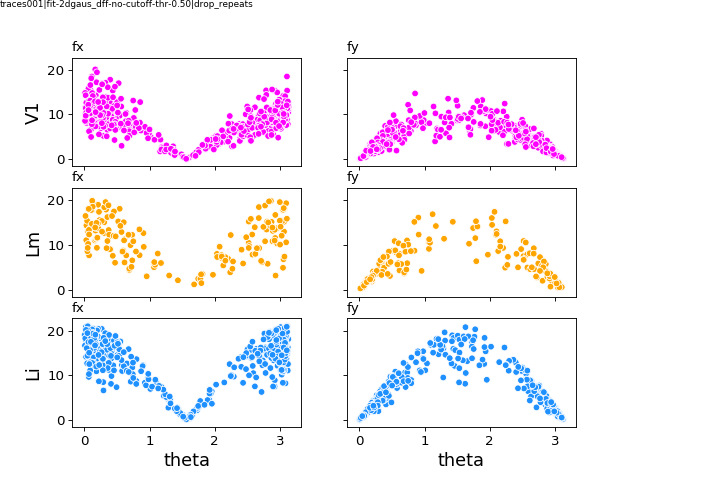

In [120]:
fig, axn = pl.subplots(3,2,figsize=(9,6), sharex=True, sharey=True)
for ri, visual_area in enumerate(visual_areas):
    g = df[df['visual_area']==visual_area]
    ax = axn[ri, 0]
    sns.scatterplot(x='theta', y='fx', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_ylabel(visual_area)
    ax.set_title('fx', loc='left')
    
    ax = axn[ri, 1]
    sns.scatterplot(x='theta', y='fy', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    #pl.legend(bbox_to_anchor=(1.1,1))
    ax.set_title('fy', loc='left')
pl.subplots_adjust(wspace=0.2, right=0.8, left=0.1)
label_figure(fig, data_id)

pl.savefig(os.path.join(genstats_dir, 'fx_fy_by_theta_%s.svg' % filter_by))

In [ ]:
# def annotateBars(row, ax=ax, fontsize=12): 
#     for p in ax.patches:
#         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
#                     ha='center', va='center', fontsize=fontsize, color='k', 
#                     rotation=0, xytext=(0, 20),
#              textcoords='offset points')
        
    

In [ ]:
# def compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

#     offset = 0.25
    
#     if ax is None:
#         fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
#         fig.patch.set_alpha(0)
#         ax.patch.set_alpha(0)
    
#     # Plot paired values
#     aix=0
#     for ai, visual_area in enumerate(visual_areas):

#         plotdf = comdf[comdf['visual_area']==visual_area]
#         a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
#         b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

#         by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
#         for pi, p in enumerate(by_exp):
#             ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
#                     alpha=1, lw=0.5,  zorder=0)
#         aix = aix+1

#     # Plot average
#     sns.barplot("visual_area", curr_metric, data=comdf, 
#                 hue='experiment', #zorder=0,
#                 ax=ax, order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     ax.legend_.remove()

#     set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
    return ax


In [62]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

In [131]:
curr_metric = 'std'
params = ['x0', 'y0', 'theta', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(params)

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


# Visualize general stats

### 1. Average RF size

<IPython.core.display.Javascript object>


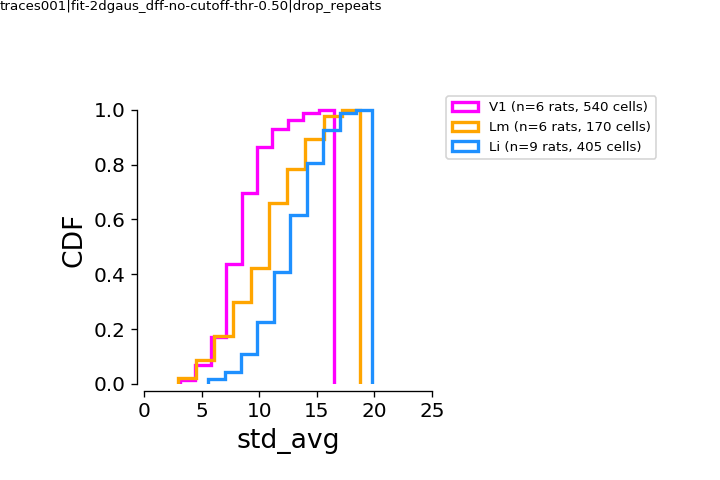

std_avg_drop_repeats_cdf


In [122]:
curr_metric = 'std_avg'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30
#for experiment, expdf in rfdf.groupby(['experiment']):

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(df, metric=curr_metric, cdf=cdf, ax=ax, alpha=1)
ax.set_xlim([0, 25])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, '%s' % (data_id))
figname = '%s_%s_%s' % (curr_metric, filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

In [123]:
mean_sizes

visual_area              datakey    std_avg
0           Li  20190522_JC089_fov1  14.125163
1           Li  20190527_JC092_fov2  13.457365
2           Li  20190527_JC092_fov3  12.267896
3           Li  20190528_JC092_fov1  13.582320
4           Li  20190605_JC090_fov1  14.165804
5           Li  20190607_JC091_fov1  13.119728
6           Li  20190612_JC099_fov1  13.479894
7           Li  20190614_JC091_fov1  13.062281
8           Li  20190617_JC099_fov1  12.532571
9           Li  20191003_JC111_fov1  13.113333
10          Li  20191007_JC091_fov1  13.662070
11          Li  20191008_JC091_fov1  13.342374
12          Li  20191018_JC113_fov1  12.789248
13          Li  20191105_JC117_fov1  13.688065
14          Li  20191111_JC120_fov1  12.486939
15          Lm  20190602_JC080_fov2  11.158928
16          Lm  20190618_JC097_fov1  10.454305
17          Lm  20191004_JC110_fov3  12.591393
18          Lm  20191004_JC110_fov4  11.520776
19          Lm  20191012_JC113_fov3  12.342155
20          Lm  20191104_JC117_fov2  10.005941
21          Lm  20191106_JC120_fov4  13.410509
22          Lm  20191111_JC117_fov2  12.358567
23          V1  20190420_JC076_fov1   9.108206
24          V1  20190511_JC083_fov1   8.588291
25          V1  20190522_JC084_fov1  10.141840
26          V1  20190613_JC097_fov1   9.244314
27          V1  20190616_JC097_fov1   7.891846
28          V1  20190617_JC097_fov1   8.168665
29          V1  20190622_JC085_fov1  10.162788
30          V1  20191006_JC110_fov1   8.788104

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


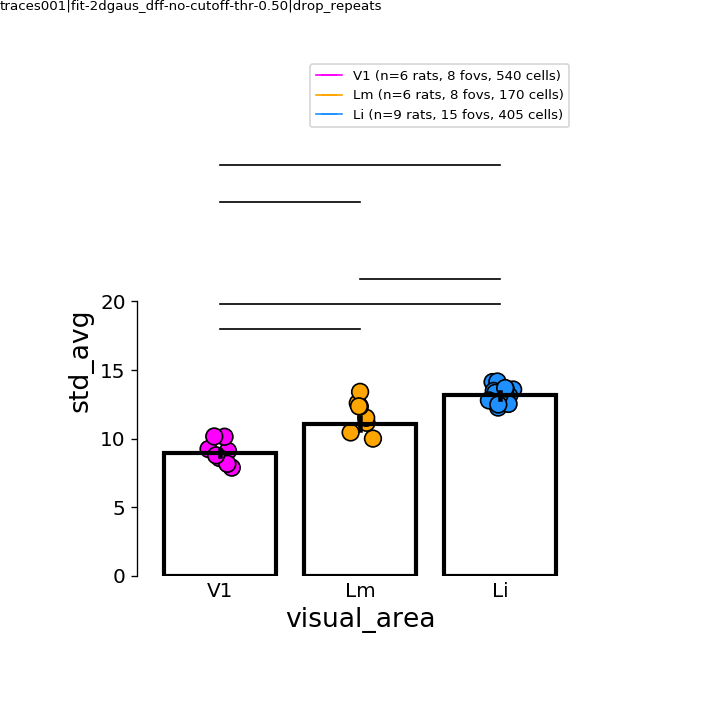

********* std_avg **********
[('V1', 'Lm')] Statistics=27482.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=25989.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=22185.000, p=0.000, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 2.8557046912756324e-15), (('V1', 'Li'), True, 1.7884416814441629e-89), (('Lm', 'Li'), True, 8.3255440408027306e-12)]
18.0
****************************
std_avg_sigma_groupby-datakey_mean-fov_drop_repeats__multicomp-holm_ci


In [124]:
curr_metric = 'std_avg'
multi_comp_test = 'holm'
mean_metric = 'mean'
groupby = 'datakey'

# for experiment, expdf in rfdf.groupby(['experiment']):

# Average RF sizes for each FOV
if groupby is not None:
    grped = df.groupby(['visual_area', groupby])
    group_str = 'groupby-%s' % groupby
else:
    grped = df.groupby(['visual_area'])
    group_str = ''


if mean_metric == 'median':
    mean_sizes = grped.median()[curr_metric].reset_index()
else:
    mean_sizes = grped.mean()[curr_metric].reset_index()

fig, ax = pl.subplots(figsize=(6,6), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=df, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=mean_sizes, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(df, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


label_figure(fig, data_id)
figname = '%s_%s_%s_%s-fov_%s__multicomp-%s_ci' % (curr_metric, sigma_str, group_str, mean_metric, filter_by, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

In [125]:

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(mean_sizes, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
#annotate_stats_areas(statresults, ax)
print("****************************")

********* std_avg **********
[('V1', 'Lm')] Statistics=2.000, p=0.001, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=0.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=13.000, p=0.001, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 0.0019475275859466652), (('V1', 'Li'), True, 0.00018401959621917283), (('Lm', 'Li'), True, 0.0019475275859466652)]
****************************


## Distn of all rf sizes

<IPython.core.display.Javascript object>


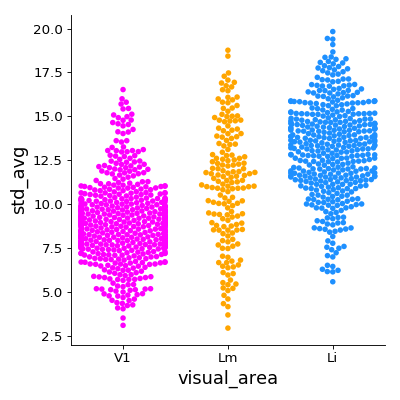

std_avg_distns_drop_repeats


In [126]:
curr_metric = 'std_avg'
plot_kind = 'swarm'

fg = sns.catplot(x="visual_area", y=curr_metric, data=df,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = '%s_distns_%s' % (curr_metric, filter_by)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

## Look at N cells fit 

In [127]:
countdf = df.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)


<IPython.core.display.Javascript object>


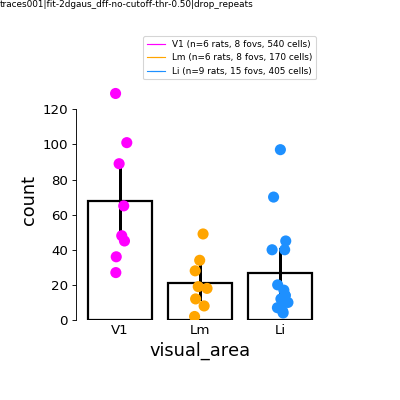

********* n_cells **********
[('V1', 'Lm')] Statistics=6.000, p=0.004, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=17.500, p=0.003, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=59.500, p=0.500, ... Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.0099783121620008151), (('V1', 'Li'), True, 0.0099783121620008151), (('Lm', 'Li'), False, 0.5)]
27.24
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'n_cells_avg-fov_drop_repeats__multicomp-holm')


In [128]:
curr_metric = 'n_cells'
fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')


#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)



print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax, lw=1, color='k', 
                         visual_areas=['V1', 'Lm', 'Li'])
   
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_avg-fov_%s__multicomp-%s' % (curr_metric, filter_by, multi_comp_test)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [129]:
params

['x0',
 'y0',
 'theta',
 'fwhm_x',
 'fwhm_y',
 'fwhm_avg',
 'fx',
 'fy',
 'visual_area']

<IPython.core.display.Javascript object>


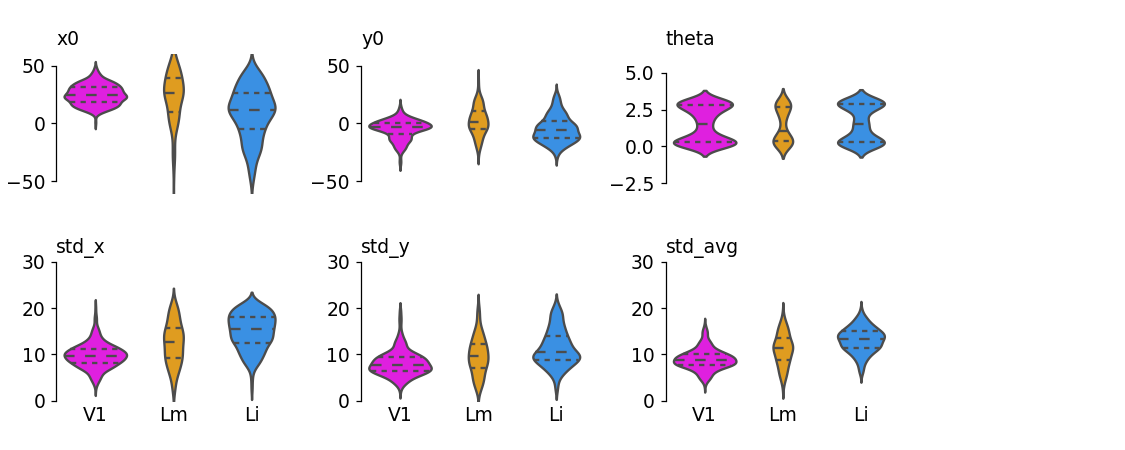

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'all-metrics_drop_repeats_violin')


In [135]:
plot_type = 'violin'

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=df, ax=ax,
                      palette=area_colors, order=visual_areas,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=df, ax=ax,
                      palette=area_colors, dodge=True, order=visual_areas)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)

    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
    if param=='theta':
        ax.set_ylim([-np.pi, 2*np.pi])
    elif param in ['x0','y0']:
        ax.set_ylim([-60, 60])
    elif 'fwhm' in param:
        ax.set_ylim([0, 60])
    elif 'std' in param:
        ax.set_ylim([0, 30])
    sns.despine(trim=True, ax=ax, bottom=True)
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_%s_%s' % (filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(genstats_dir, figname)    

# Compare cortical position vs. VF position

In [55]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = coords.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = coords.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [136]:
scatter_dir = os.path.join(outdir, 'scatter', '%s_2' %filter_by)
if not os.path.exists(scatter_dir):
    os.makedirs(scatter_dir)
print(scatter_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats_2


#### Load converted RF positions

In [143]:
from pipeline.python.rois.utils import load_roi_coords

In [193]:
reliable_str = 'reliable' if reliable_only else 'allfit'
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s.pkl' % (filter_by, reliable_str))


In [196]:
with open(df_fpath, 'wb') as f:
    pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable.pkl


In [58]:
get_positions = False

if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'wb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
    
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        df[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in df.groupby(['animalid', 'session', 'fovnum']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(df, f, protocol=pkl.HIGHETS_PROTOCOL)
    

Calculating RF coord conversions...
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e280bf_traces001_113086_traces001_caa531_traces001_d04d75_traces001_5735eb/data_arrays/np_subtracted.npz
NP_subtracted offset was: 62.54
adding NP offset... (NP baseline offset: 284.05)
((258720, 300), (300,), ())
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC076] 20190501 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
...

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 314 contours for rois.
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190615|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/combined_rfs10_static/traces/traces001_82391c_traces001_5005be_traces001_b13324/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190615 | FOV2_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 338 contours for rois.
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_30490f_traces001_8ad808/data_arrays/np_subtracted.npz
NP_subtracted offset was: 199.97
adding NP offset... (NP baseline offset: 777.42)
((58740, 432), (432,), ())
... updating self
... ... loaded traces
Created 432 contours for rois.
[JC097] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC097|20190617|F

((239232, 295), (295,), ())
... adjusting for equal reps / condn...
... updating self
... ... loaded traces
Created 295 contours for rois.
[JC078] 20190513 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC078 | 20190513 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC078|20190513|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 118.47
adding NP offset... (NP baseline offset: 565.59)
((246708, 280), (280,), ())
... updating self
... ... loaded traces
Created 280 contours for rois.
[JC080] 20190506 - FOV1_zoom2p0x:  Getting anatomicals...
... Fou

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 183 contours for rois.
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_48087b_traces001_eb1ab1_traces001_34291b_traces001_83220d_traces001_15ae76_traces001_b0ea86/data_arrays/np_subtracted.npz
NP_subtracted offset was: 76.00
adding NP offset... (NP baseline offset: 762.38)
((246708, 275), (275,), ())
... updating self
... ... loaded traces
Created 275 contours for rois.
[JC083] 20190508 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190508 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment da

NP_subtracted offset was: 12.59
adding NP offset... (NP baseline offset: 951.29)
((65340, 191), (191,), ())
... updating self
... ... loaded traces
Created 191 contours for rois.
[JC120] 20191106 - FOV4_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC120 | 20191106 | FOV4_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC120|20191106|FOV4_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC120/20191106/FOV4_zoom2p0x/combined_rfs10_static/traces/traces001_0576f9_traces001_b3ca84/data_arrays/np_subtracted.npz
NP_subtracted offset was: 39.18
adding NP offset... (NP baseline offset: 655.99)
((43560, 252), (252,), ())
... updating self
... ... loaded traces
Created 252 contours for rois.
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 271 contours for rois.
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190602 | FOV1_zoom2p0x | rfs | traces001
Found 68 raw file arrays.
**** File 1 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last fra

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 350.52801598995484)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.3023850085
... processing trace type: np_subtracted
('drift offset:', 59.605280853702936)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -344.885500791
... processing trace type: raw
('drift offset:', 319.97047624771892)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -402.237215909
STIM TYPE: gratings
**** File 9 of 68 *****
*** Excluding: []
/n/coxfs01

('drift offset:', 312.03211695112469)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -248.714653201
STIM TYPE: gratings
**** File 16 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 252 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 344.5981799057451)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.8782403771
... processing trace type: np_subtracted
('drift offset:', 58.358003168446473)
Showing initial drift correction (quantile: 0.10)
Min value

('drift offset:', 54.006579914972981)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -264.829173906
... processing trace type: raw
('drift offset:', 310.74628399077261)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -257.655776515
STIM TYPE: gratings
**** File 24 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 338.84951805175473)
Showing initial drift correction (quantile: 0.10)
Min value for all 

('drift offset:', 334.73203512998327)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.082361516
... processing trace type: np_subtracted
('drift offset:', 63.819681362169057)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -359.407776414
... processing trace type: raw
('drift offset:', 313.08143192928441)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -367.260357481
STIM TYPE: gratings
**** File 32 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 270 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimul

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currdf['ix'] = [total_ix for _ in range(currdf.shape[0])]
/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currf0['ix'] = [total_ix for _ in range(currdf.shape[0])]



('drift offset:', 50.367677066395402)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -303.654811357
... processing trace type: raw
('drift offset:', 285.18829935342387)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -283.293969131
STIM TYPE: gratings
**** File 36 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 314.42321350828666)
Showing initial drift correction (quantile: 0.10)
Min value for all

('drift offset:', 312.97108705112311)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -70.1804623415
... processing trace type: np_subtracted
('drift offset:', 53.687284570494505)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -249.718819594
... processing trace type: raw
('drift offset:', 287.47798808372193)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -277.856343284
STIM TYPE: gratings
**** File 44 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimu

('drift offset:', 423.63992371150766)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.4368663594
... processing trace type: np_subtracted
('drift offset:', 89.243632775241736)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -295.380285562
... processing trace type: raw
('drift offset:', 403.75418788362231)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -308.34469697
STIM TYPE: gratings
**** File 52 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 5 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimul

... processing trace type: neuropil
('drift offset:', 404.58304855040677)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.8106235566
... processing trace type: np_subtracted
('drift offset:', 78.818183183642475)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.105858008
... processing trace type: raw
('drift offset:', 379.7834305217803)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.934997559
STIM TYPE: gratings
**** File 60 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 2 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials i

('drift offset:', 397.33172730823827)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.7858990944
... processing trace type: np_subtracted
('drift offset:', 74.475417765821788)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -238.221892475
... processing trace type: raw
('drift offset:', 370.97784208967806)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -253.244658499
STIM TYPE: gratings
**** File 68 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 10 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stim

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1044, in load
    dset = np.load(soma_fpath)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 370, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz'


Created 356 contours for rois.
[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_05849a_traces001_593095_traces001_71ffc1_traces001_60af14/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190606 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 314 contours for rois.
[JC091] 20190607 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190607|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_37d16e_traces001_638646_traces001_7109e9_traces001_22f46d/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190607 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 526 contours for rois.
[JC091] 20190614 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190614 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 533 contours for rois.
[JC091] 20191007 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC091 | 20191007 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20191007|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20191007/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_825373_traces001_25120e/data_arrays/np_subtracted.npz
NP_subtracted offset was: -12.99
adding NP offset... (NP baseline offset: 563.00)
((43560, 407), (407,), ())
... updating self
... ... loaded traces
Created 407 contours for rois.
[JC091] 20191008 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC091 | 20191008 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 311 contours for rois.
[JC099] 20190612 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_c582b7_traces001_d52cff_traces001_50de2d_traces001_1a8b92/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190612 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 269 contours for rois.
[JC099] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190617 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 102 contours for rois.
[JC111] 20191003 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC111|20191003|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC111/20191003/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_4856d2_traces001_79f9fd_traces001_07b47b_traces001_c61642/data_arrays/np_subtracted.npz
NP_subtracted offset was: 190.12
adding NP offset... (NP baseline offset: 2289.71)
((87120, 215), (215,), ())
... updating self
... ... loaded traces
Created 215 contours for rois.
[JC113] 20191012 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... 

# Pairwise distances

In [203]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')
import itertools

#### Look at PW distances of by dataset

In [83]:
# Create subdir
curr_sessiondir = os.path.join(pairwisedir, 'sessions')
if not os.path.exists(curr_sessiondir):
    os.makedirs(curr_sessiondir)

In [84]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0    5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1    7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2   24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3   25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4   26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

In [205]:
df.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
22  0.585001  46.670332  36.780253  2.939559 -29.065480 -11.080597    JC089   
23  0.696801  45.149795  27.452993  0.127034  13.248381 -21.937449    JC089   
24  0.876773  28.931146  20.644447  2.964704  24.519398   2.811875    JC089   
25  0.767423  31.775266  30.710669  0.442568   3.718242  11.808561    JC089   
26  0.515310  38.655484  25.170942  0.701064   8.476630   2.498789    JC089   

    cell              datakey experiment   ...           area datakey_ix  \
22    71  20190522_JC089_fov1      rfs10   ...     976.494391          1   
23    89  20190522_JC089_fov1      rfs10   ...     705.114482          1   
24    99  20190522_JC089_fov1      rfs10   ...     339.768444          1   
25   116  20190522_JC089_fov1      rfs10   ...     555.127346          1   
26   145  20190522_JC089_fov1      rfs10   ...     553.509058          1   

           fx         fy  fov_xpos  fov_ypos  fov_xpos_pix  fov_ypos_pix  \
22  19.455779   3.985095   433.246   415.011           188           218   
23  19.057864   2.434098   668.305   489.256           290           257   
24  12.119023   2.166355   695.959   603.479           302           317   
25  12.218671   5.790689   566.907   805.273           246           423   
26  12.569713  10.610211   705.177   786.236           306           413   

     ml_pos   ap_pos  
22  557.789  744.354  
23  483.544  509.295  
24  369.321  481.641  
25  167.527  610.693  
26  186.564  472.423  

[5 rows x 27 columns]

In [209]:
x = np.array([[0, 0], [30, 10], [50, 50]])
print(list(itertools.combinations(range(len(x)), 2)))

pdist(x)

[(0, 1), (0, 2), (1, 2)]


array([ 31.6227766 ,  70.71067812,  44.72135955])

In [265]:
pair_names = [('fov_x', 'ml_pos'), ('fov_y', 'ap_pos'), ('rf_x', 'x0'), ('rf_y', 'y0')]

d_list = []
# Get all pairwise distances between rf positions:
for (visual_area, animalid, session, fovnum), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    diffs={}
    for (d1, d2) in pair_names:
        xx = g[d2].values
        diffs[d1] = np.abs([t1-t2 for i, t1 in enumerate(xx) for t2 in xx[i + 1:]])
        npairs = len(list(itertools.combinations(range(len(xx)), 2)))
        assert len(diffs[d1]) == npairs, "bad combos"

    d_df = pd.DataFrame(diffs)
    d_df['animalid'] = [animalid for _ in np.arange(0, npairs)]
    d_df['session'] = [session for _ in np.arange(0, npairs)]
    d_df['fovnum'] = [fovnum for _ in np.arange(0, npairs)]
    d_df['visual_area'] = [visual_area for _ in np.arange(0, npairs)]
    d_df['datakey'] = ['%s_%s_fov%i' % (animalid, session, fovnum) for _ in np.arange(0, npairs)]

    d_list.append(d_df)
    
diff_df = pd.concat(d_list, axis=0).reset_index(drop=True)

In [266]:
print(diff_df.shape)
diff_df.head()

(35257, 9)


fov_x       fov_y       rf_x       rf_y animalid   session  fovnum  \
0   74.245010  235.059100  42.313861  10.856852    JC089  20190522       1   
1  188.468102  262.713112  53.584878  13.892473    JC089  20190522       1   
2  390.262231  133.661057  32.783722  22.889158    JC089  20190522       1   
3  371.225049  271.931115  37.542110  13.579386    JC089  20190522       1   
4  114.223092   27.654012  11.271018  24.749325    JC089  20190522       1   

  visual_area              datakey  
0          Li  JC089_20190522_fov1  
1          Li  JC089_20190522_fov1  
2          Li  JC089_20190522_fov1  
3          Li  JC089_20190522_fov1  
4          Li  JC089_20190522_fov1

In [267]:
# pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
#                 for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


In [274]:
diff_df['fov_x'].max(), diff_df['fov_x'].min()

(929.01448140900197, 0.0)

In [273]:
diff_df['rf_x'].max(), diff_df['rf_x'].min()

(100.7967207538194, 8.4825174440084083e-07)

# Split PW dist calculation by azimuth/elevation

<IPython.core.display.Javascript object>


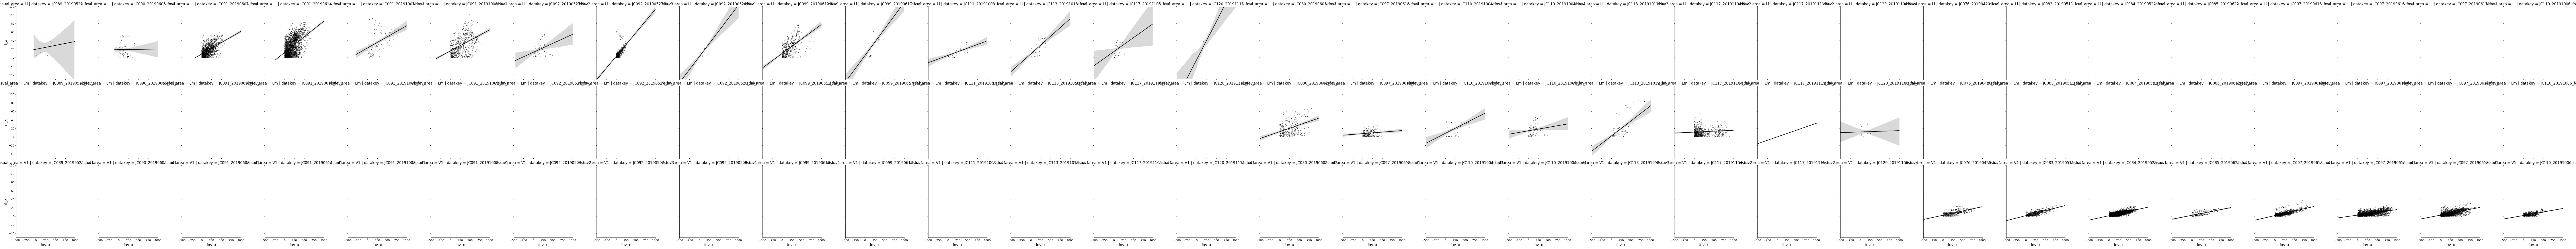

In [278]:
# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'


g = sns.lmplot('%s_x' % xvar, '%s_x' % yvar, data=diff_df, 
               row='visual_area', col='datakey', #col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)
g.set(xlim=(-500, 1000), ylim=(-50, 120))


In [ ]:
axis_ = 'y'

# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'

g = sns.lmplot('%s_%s' % (xvar, axis_), '%s_%s' % (yvar, axis_), data=diff_df, 
               row='visual_area', col='datakey', #col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)
g.set(xlim=(-500, 1000), ylim=(-50, 120))

In [86]:
import itertools

testdf = pd.DataFrame({0: np.linspace(0, 10, 10)})
                      
#[i-v for (i, v) in itertools.product(testdf.values, testdf.values)]


In [87]:
tmpd = pf[pf['visual_area']==visual_area]

# Get all pairwise distances for each fov:
tmpd_list = []
for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
    cdists = g['%s_%s' % (axname, indep_var)].values
    #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
    pwdiffs_ind = [t1-t2 for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]
    
    rdists = g['%s_%s' % (axname, dep_var)].values
    #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
    pwdiffs_dep = [t1-t2 for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]
    
    assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"
             
    tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                        '%s distance' % dep_var: pwdiffs_dep,
                        'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
    tmpd_list.append(tmpd)
pw = pd.concat(tmpd_list, axis=0)

# Plot regression w/ CI
g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)


NameError: name 'axname' is not defined

In [88]:
plot_azimuth= True

<IPython.core.display.Javascript object>


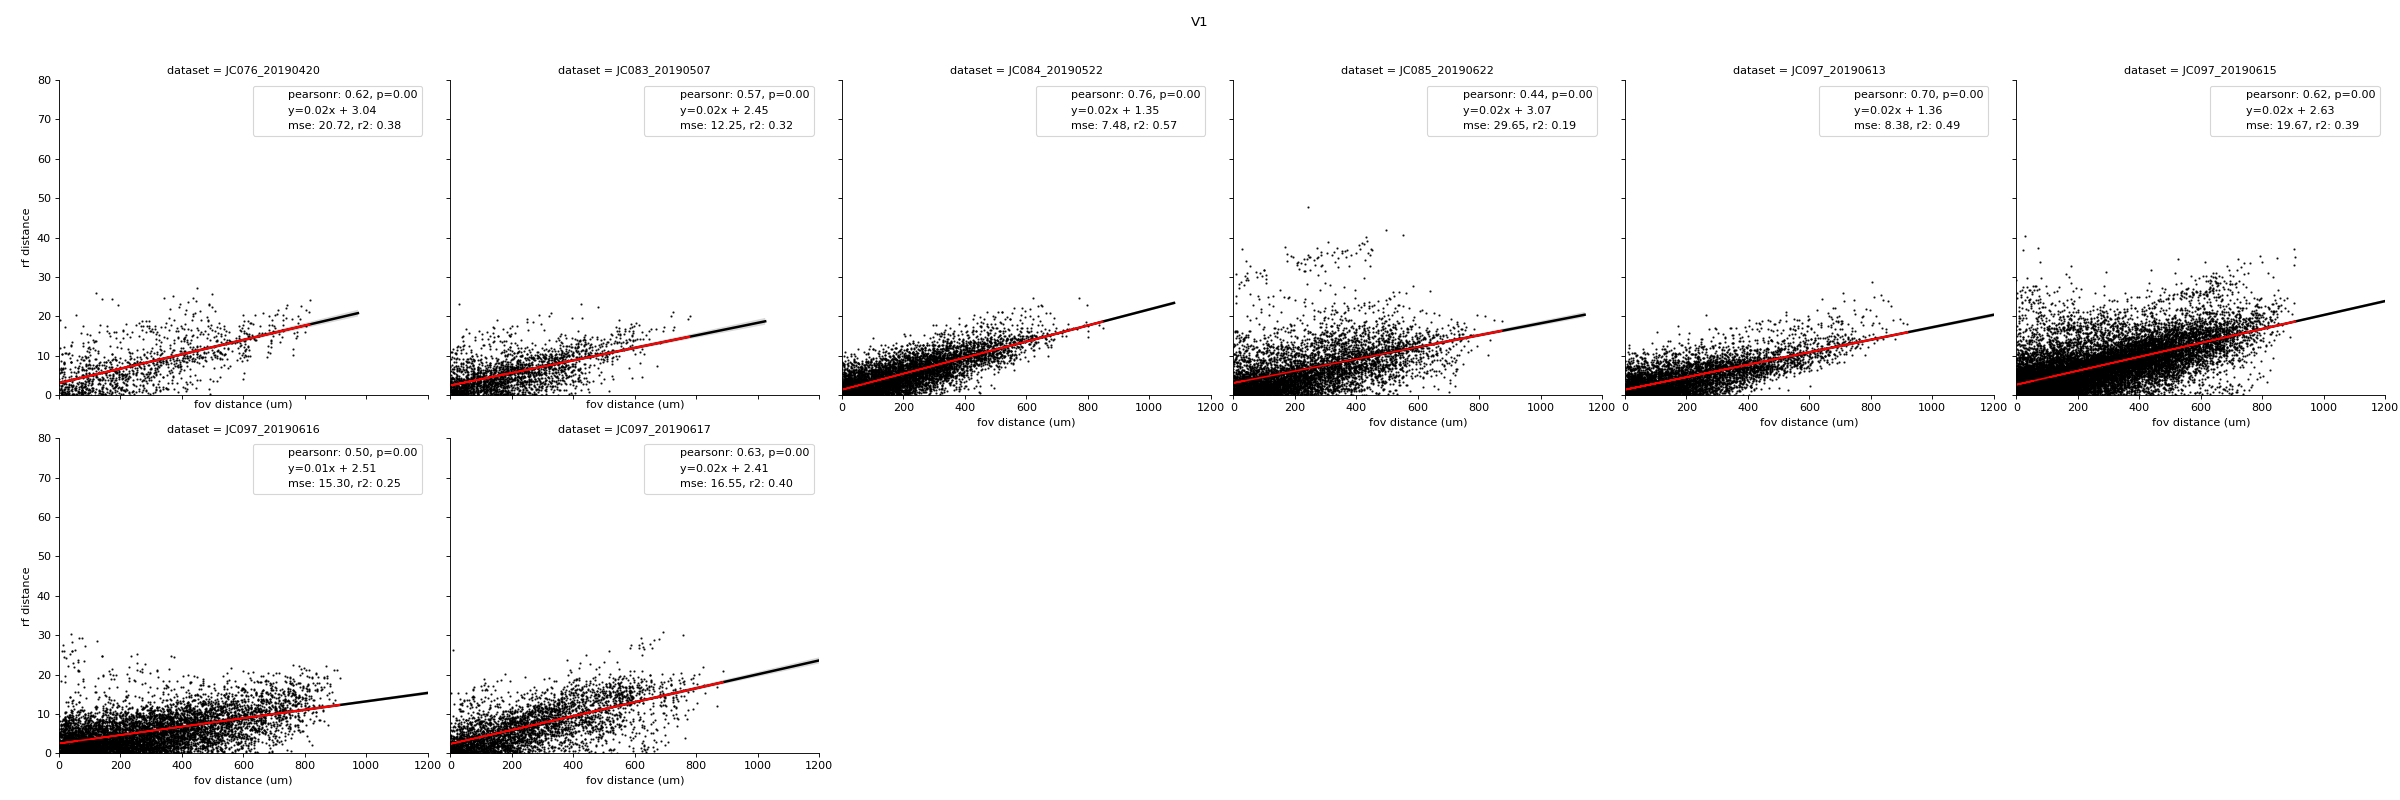

<IPython.core.display.Javascript object>


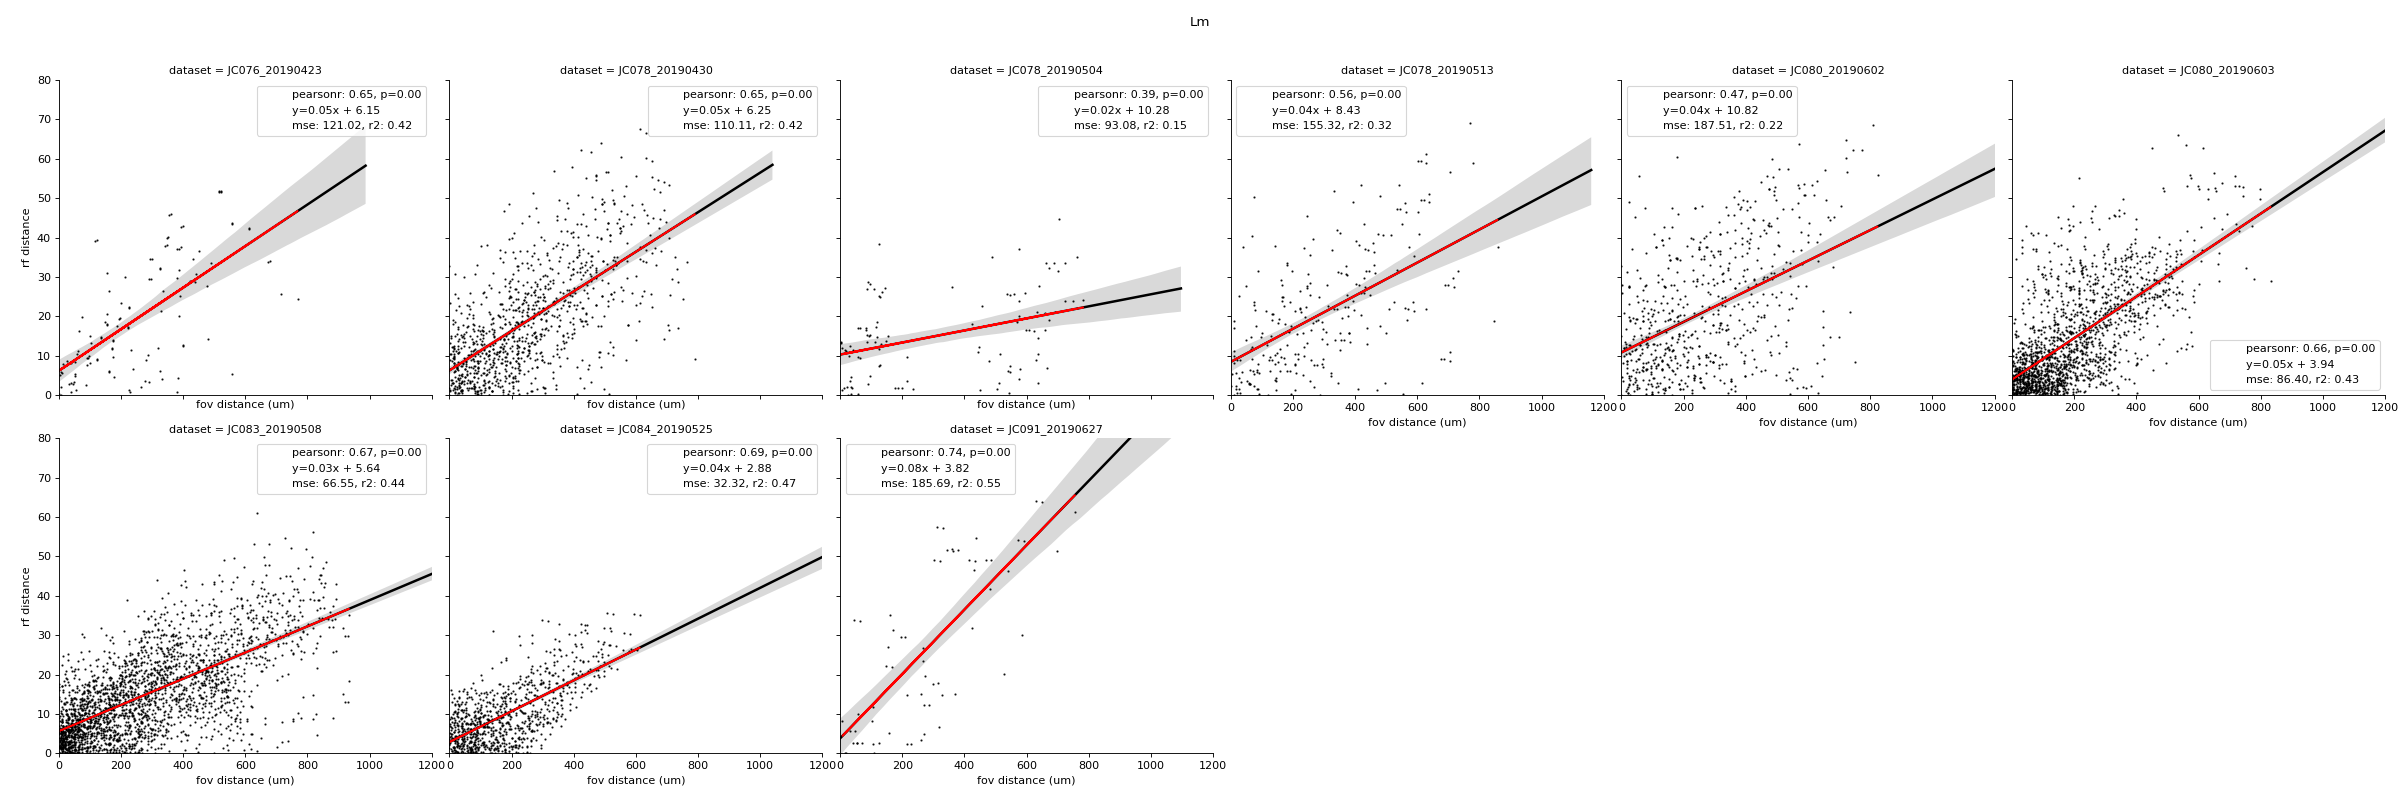

<IPython.core.display.Javascript object>


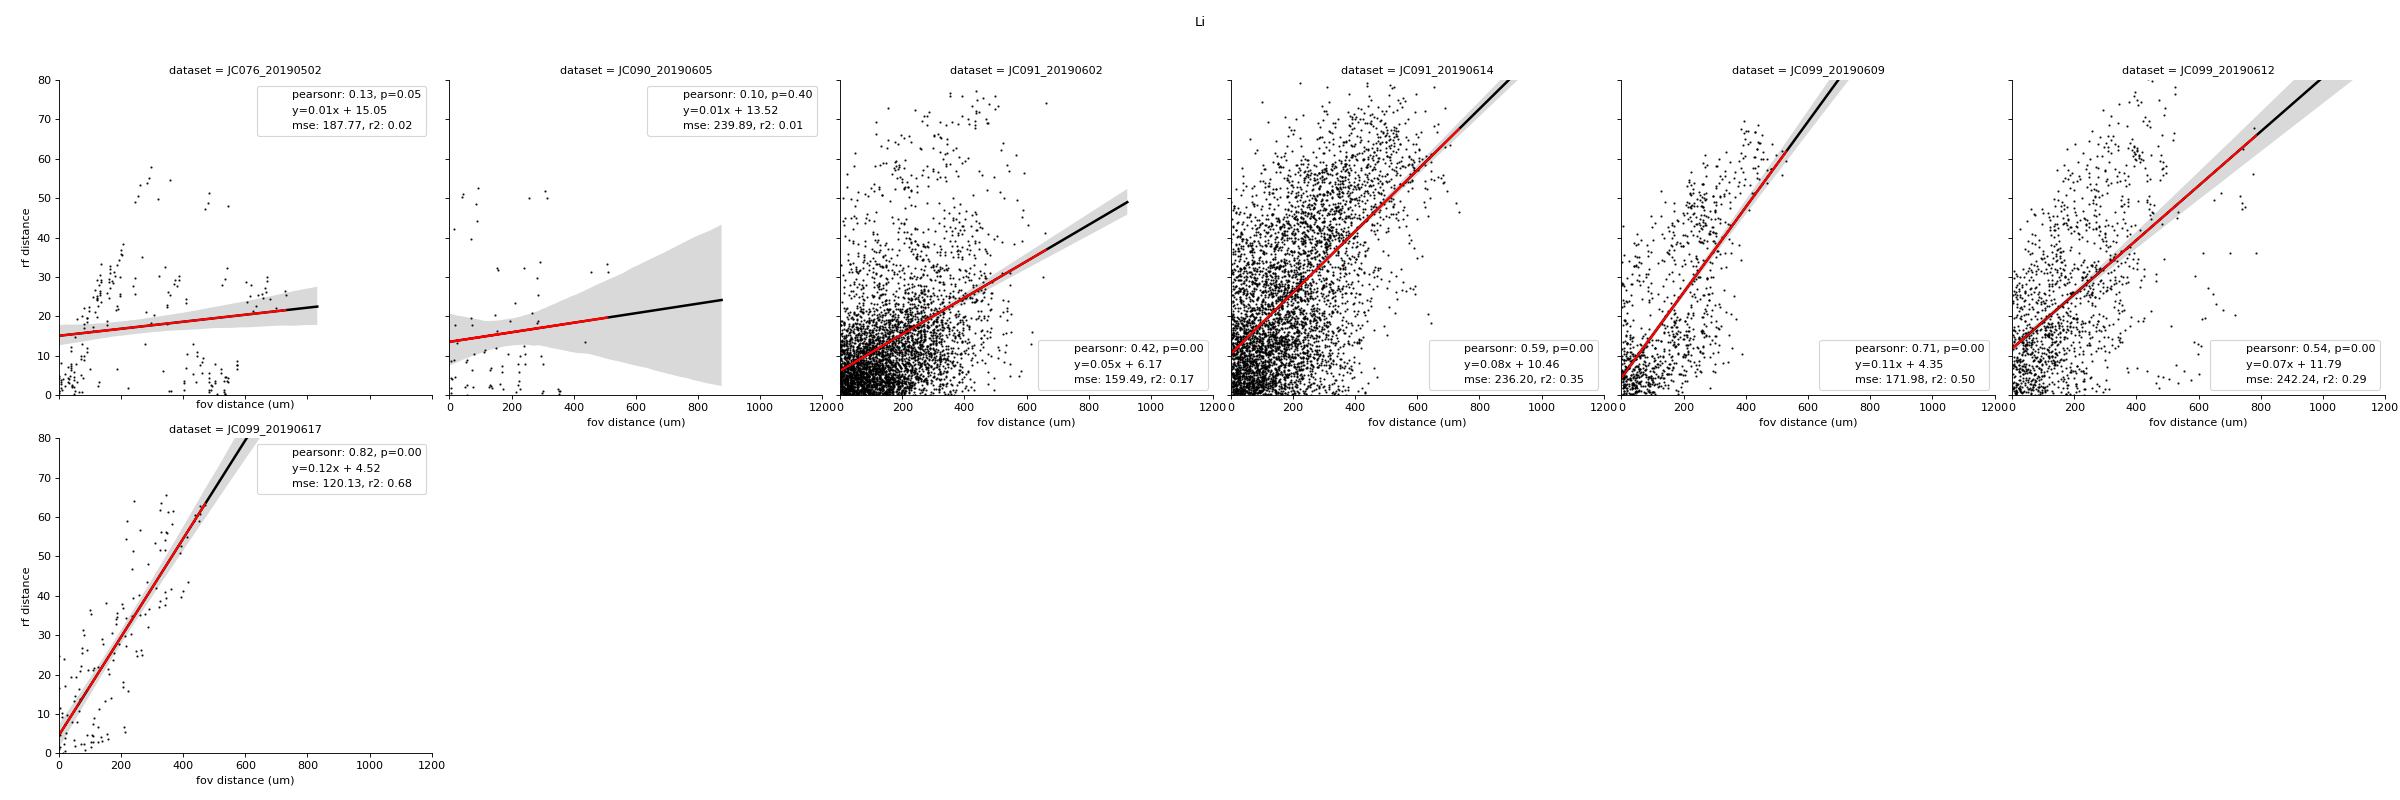

In [130]:
dep_var = 'rf' if indep_var=='fov' else 'fov'
axname = 'xpos' if plot_azimuth else 'ypos'

plot_str = 'azimuth' if plot_azimuth else 'elevation'
xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = g['%s_%s' % (axname, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = [ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]

        rdists = g['%s_%s' % (axname, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = [ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]

        assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"

        tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                            '%s distance' % dep_var: pwdiffs_dep,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)


    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([0, xmax])
        ax.set_ylim([0, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, '%s-only_regr-on-%s_%s.png' % (plot_str, visual_area, indep_var)))


In [89]:
curr_sessiondir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff/pairwise-distances/sessions'

### Get stats for PW dists split by el, az

In [90]:
pwdiffs_ind

NameError: name 'pwdiffs_ind' is not defined

In [91]:

pwstats_split = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    for axn in ['xpos', 'ypos']:

        # Get all pairwise distances for current fov:
        cdists = g['%s_%s' % (axn, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = np.array([ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]])

        rdists = g['%s_%s' % (axn, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = np.array([ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]])


        # Get linear fit:
        fitdist, regr = fit_linear_regr(pwdiffs_ind, pwdiffs_dep, return_regr=True)
        mse = skmetrics.mean_squared_error(pwdiffs_dep, fitdist)
        r2 = skmetrics.r2_score(pwdiffs_dep, fitdist)
        res = pd.Series({'visual_area': visual_area,
                             'animalid': animalid,
                             'session': session,
                             'fov': fov,
                             'RMSE': np.sqrt(mse),
                             'R2': r2,
                             'slope': float(regr.coef_),
                             'intercept': float(regr.intercept_),
                             'axis': axn,
                             'dataset': '_'.join([animalid, session, fov])})
        pwstats_split.append(res)

pwstats_split = pd.concat(pwstats_split, axis=1).T

In [93]:
g.shape

(59, 15)

In [94]:
len(pwdiffs_dep)

1711

In [92]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

#### Plot PW stts for SPLITs

<IPython.core.display.Javascript object>


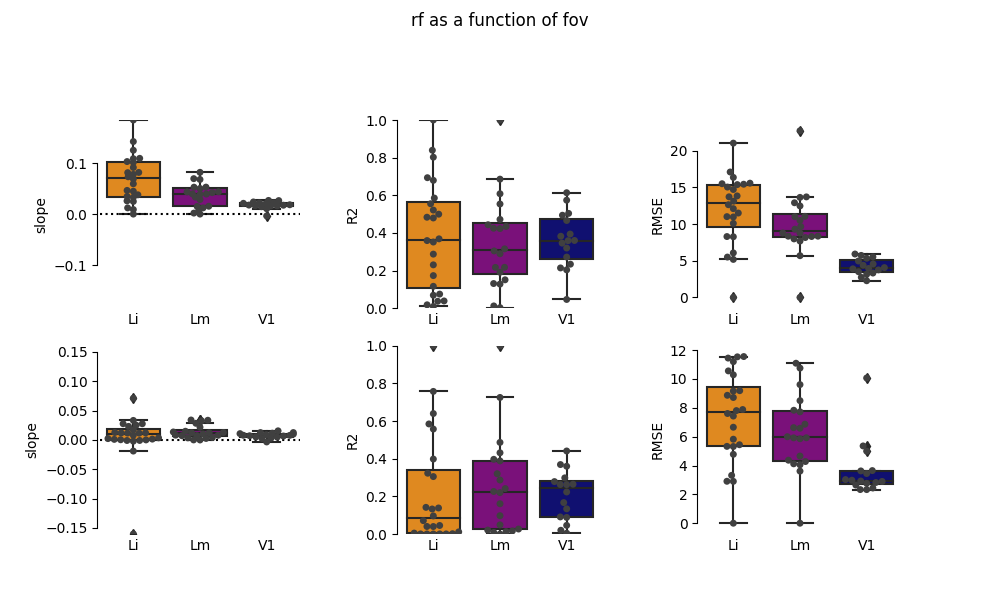

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
fig, axes = pl.subplots(2, 3, figsize=(10,6))
fig.patch.set_alpha(1)

for ai, axn in enumerate(['xpos', 'ypos']):
    curr_pwstats = pwstats_split.groupby(['axis']).get_group(axn)

    ax1 = boxplot_visual_area(curr_pwstats, metric='slope', ax=axes[ai, 0], area_colors=area_colors)

    ax2 = boxplot_visual_area(curr_pwstats, metric='R2', ax=axes[ai, 1], area_colors=area_colors)

    ax3 = boxplot_visual_area(curr_pwstats, metric='RMSE', ax=axes[ai, 2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'split-axes_stats-regr-on-%s_bmo.svg' % indep_var))

In [96]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax



#### PW dists, split:  Plot slope for Az and El on same 

In [97]:
axdf.groupby(['visual_area'])['slope'].apply(np.mean)

NameError: name 'axdf' is not defined

<IPython.core.display.Javascript object>


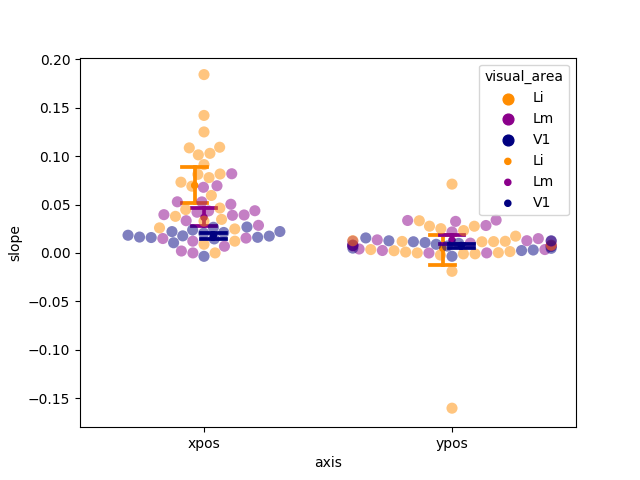

In [98]:
fig, ax = pl.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([0, 0],[0, 0], marker='s')
b = ax.scatter([0, 0],[0, 0], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="axis", y="slope", hue="visual_area",data=pwstats_split, 
                   palette=area_colors,size=8,ax=ax, dodge=False, alpha=0.5,facecolor='none')
N_hues = len(pd.unique(pwstats_split.visual_area))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
#update legend
ax.legend(c[-3:],pd.unique(pwstats_split.visual_area))


mvs = pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)

sns.pointplot(x='axis', y='slope', hue='visual_area', data=pwstats_split, ci=95, capsize=0.1,
             palette=area_colors, dodge=True, apha=0.7, markers='.', join=False)


In [185]:
pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)


axis  visual_area
xpos  Li             0.063929
      Lm             0.045119
      V1             0.016610
ypos  Li             0.009870
      Lm             0.020191
      V1             0.009434
Name: slope, dtype: float64

In [99]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

<IPython.core.display.Javascript object>


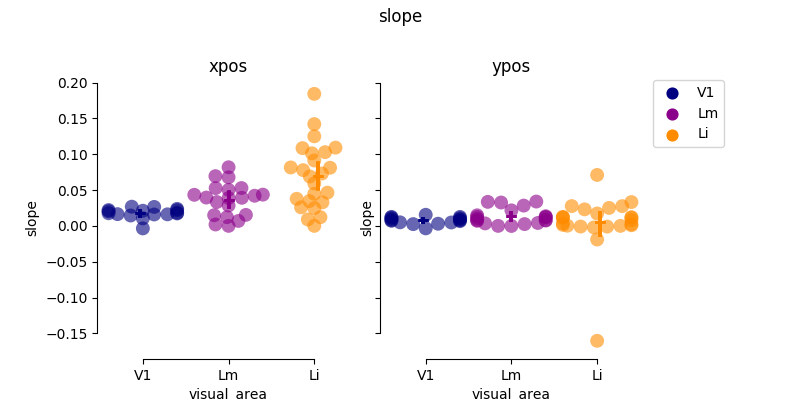

In [100]:

metric = 'slope'
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

for ax, axn in zip(axes.flat, ['xpos', 'ypos']):
    axdf = pwstats_split[pwstats_split['axis']==axn]
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

       # ax.plot(ai, mval, color=area_colors[visual_area], marker='_', markersize=30)
        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axn)
    if axn == 'xpos':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8)
fig.suptitle(metric)

pl.savefig(os.path.join(pairwisedir, '%s_pw-dists_ax-v-el_bmo.svg' % metric))


In [141]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

# Combine axes: PW distance regression for each dataset for each visual area

In [79]:
indep_var

'fov'

<IPython.core.display.Javascript object>


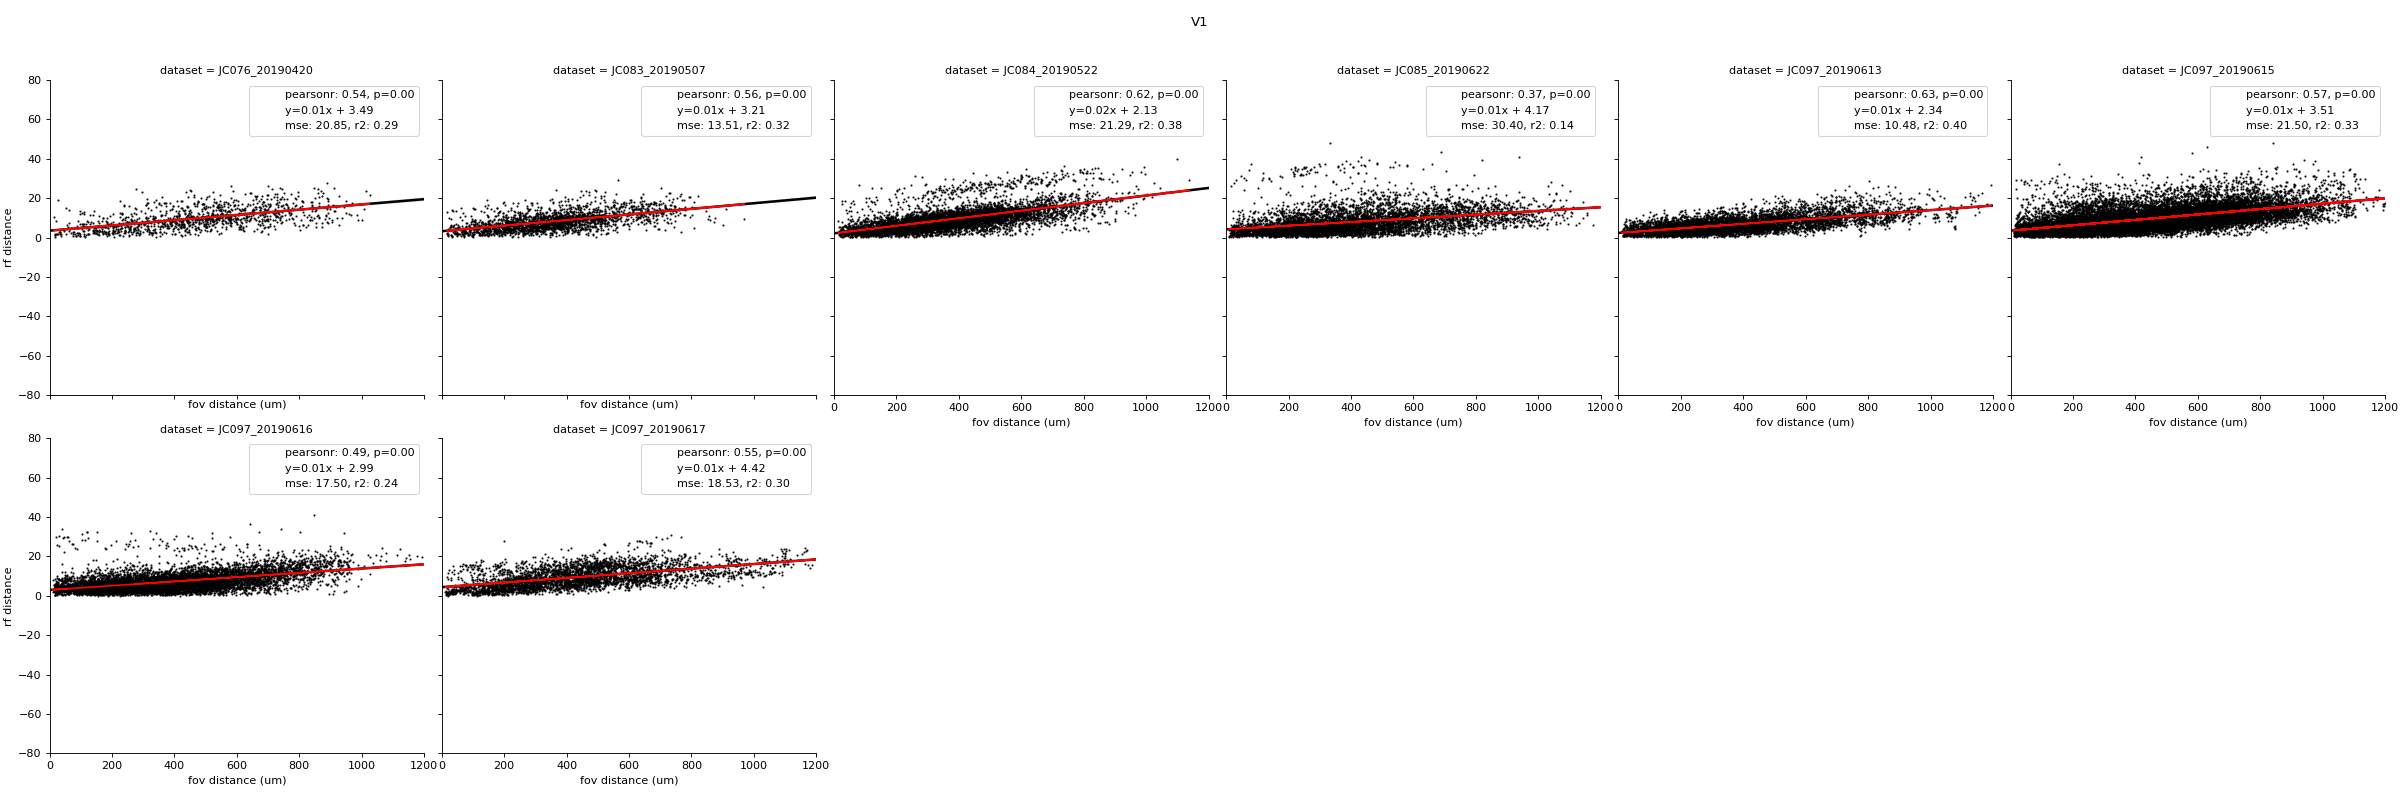

<IPython.core.display.Javascript object>


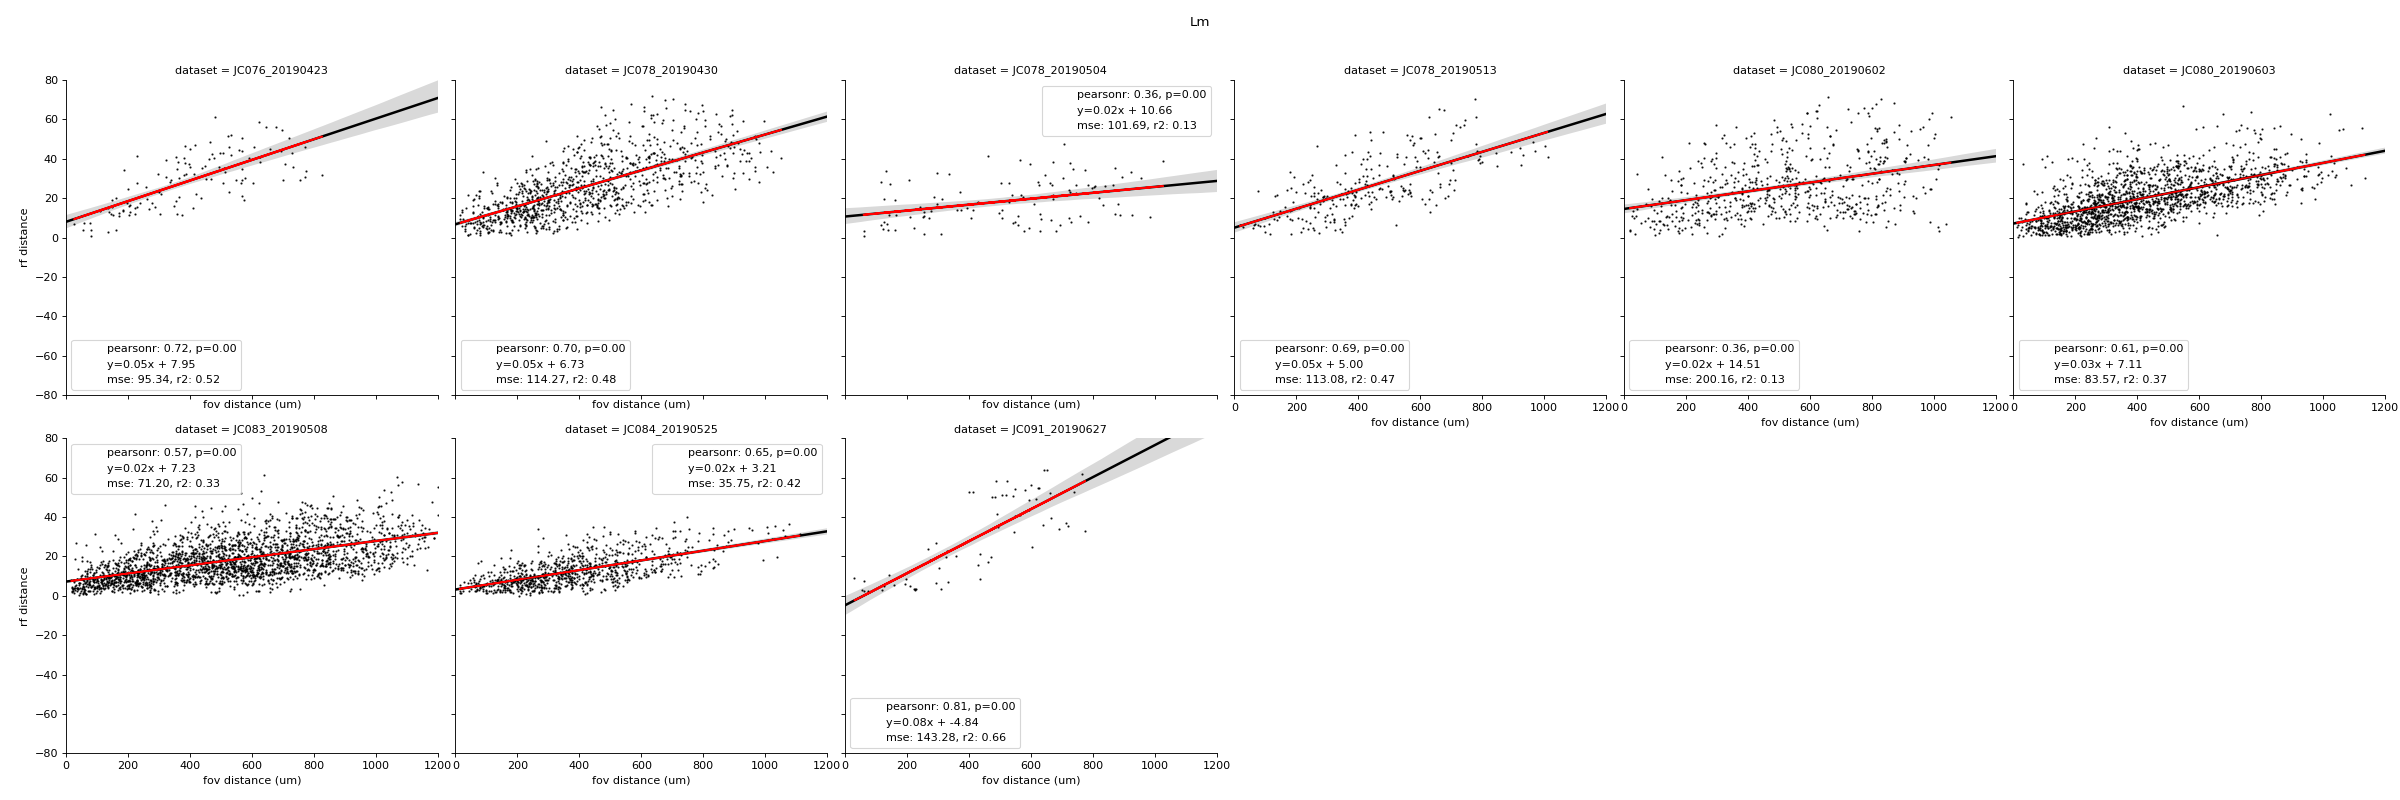

<IPython.core.display.Javascript object>


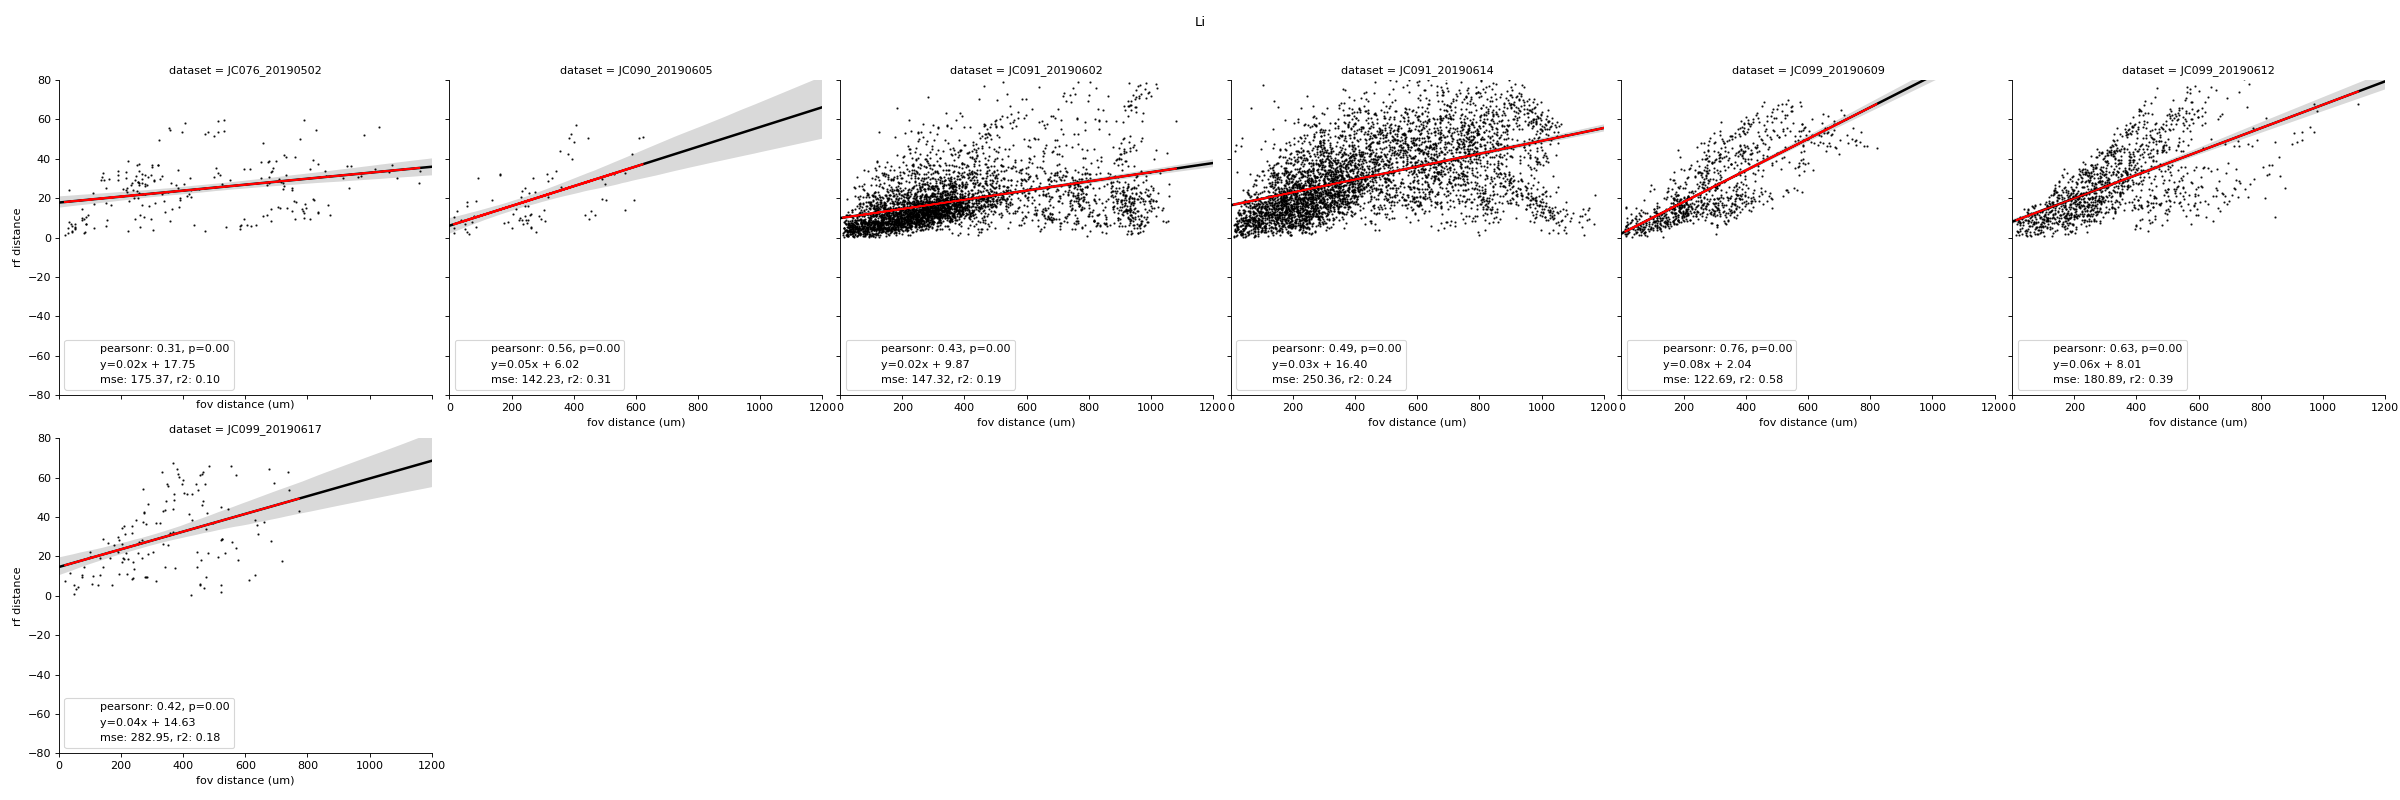

In [84]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200


# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

R2     RMSE         dataset intercept       slope visual_area
0  0.291849   4.5666  JC076_20190420   3.49435   0.0133151          V1
1  0.110722  6.13418  JC076_20190501   6.32593  0.00917705          V1
2  0.317121  3.67584  JC083_20190507   3.21438   0.0141987          V1
3  0.177895  5.95603  JC083_20190510     5.859   0.0142868          V1
4   0.39773  3.88048  JC083_20190511   2.64958   0.0186305          V1

In [96]:
del reginfo

In [85]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [86]:
pwstats.head()

R2     RMSE animalid                       dataset            fov  \
0  0.0953611  13.2428    JC076  JC076_20190502_FOV1_zoom2p0x  FOV1_zoom2p0x   
1    0.31371  11.9261    JC090  JC090_20190605_FOV1_zoom2p0x  FOV1_zoom2p0x   
2   0.186778  12.1375    JC091  JC091_20190602_FOV1_zoom2p0x  FOV1_zoom2p0x   
3   0.243542  15.8227    JC091  JC091_20190614_FOV1_zoom2p0x  FOV1_zoom2p0x   
4   0.584282  11.0767    JC099  JC099_20190609_FOV1_zoom2p0x  FOV1_zoom2p0x   

  intercept   session      slope visual_area  
0   17.7525  20190502  0.0151595          Li  
1   6.01845  20190605  0.0501515          Li  
2   9.86805  20190602  0.0233078          Li  
3   16.3973  20190614  0.0326908          Li  
4   2.04233  20190609  0.0800883          Li

<IPython.core.display.Javascript object>


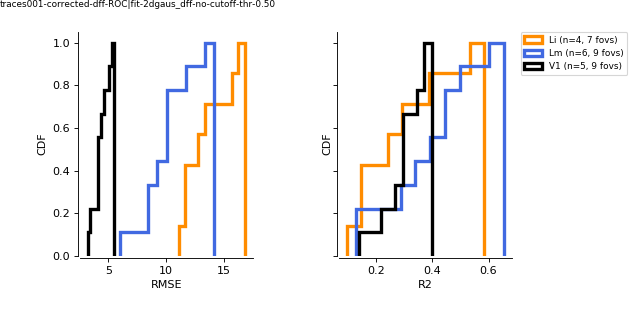

In [87]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


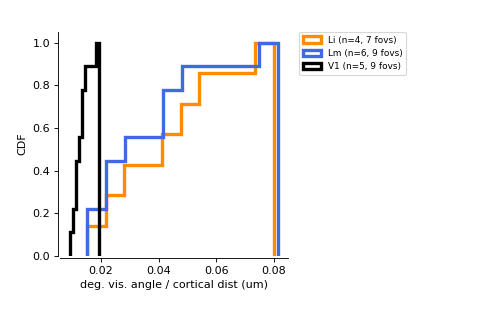

In [88]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


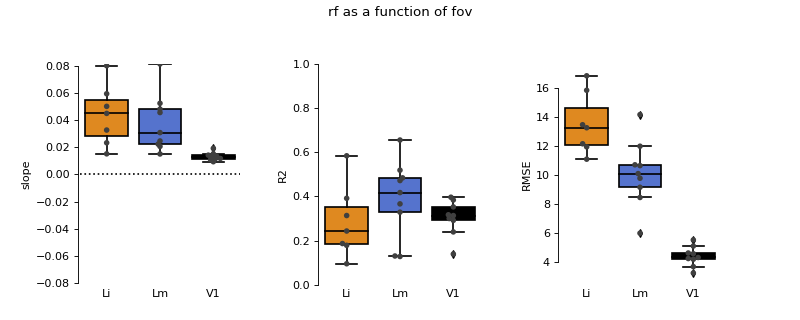

In [89]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

<IPython.core.display.Javascript object>


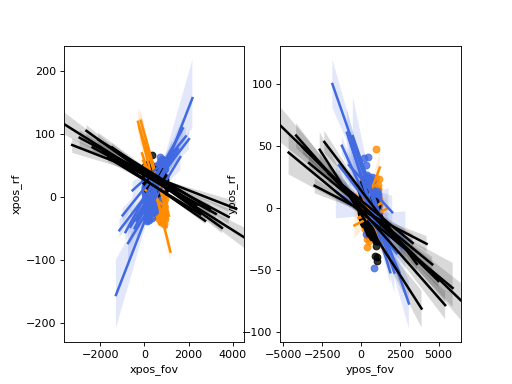

In [90]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [101]:
df.head()

r2    sigma_x    sigma_y     theta         x0         y0 animalid  \
13  0.592816  13.408074  11.469334 -0.288729  12.200497   0.748017    JC089   
14  0.554771  19.490870  10.009762 -0.994947 -51.552794  10.413053    JC089   
15  0.512692  11.433837   5.652660 -0.673435   4.479900   0.366059    JC089   
16  0.571984  15.485803   9.977350  0.513668   8.736586   1.810410    JC089   
17  0.800984  13.283970  14.656829 -0.968406   4.725769  11.074534    JC089   

    cell              datakey experiment   session visual_area   avg_size  \
13   113  20190522_JC089_fov1      rfs10  20190522          Li  12.438704   
14    11  20190522_JC089_fov1      rfs10  20190522          Li  14.750316   
15    80  20190522_JC089_fov1      rfs10  20190522          Li   8.543248   
16   145  20190522_JC089_fov1      rfs10  20190522          Li  12.731577   
17   116  20190522_JC089_fov1      rfs10  20190522          Li  13.970399   

    datakey_ix        fx        fy  
13           1  6.426534  1.908865  
14           1  5.306854  8.173787  
15           1  4.468822  3.565500  
16           1  6.743666  3.804668  
17           1  4.152378  6.038495

In [104]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fovnum), tmpd in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC089] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC089 | 20190522 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
[JC089|20190522] No experiment exists for: blobs
[JC089|20190522|FOV1_zoom2p0x] creating gratings object
Getting stimulus info for: combined_gratings_static


AssertionError: [gratings] more than 1 xpos found! []

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

r2    sigma_x    sigma_y     theta         x0         y0   cell  \
0    0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018    0.0   
1    0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950    2.0   
2    0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272    5.0   
3    0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018    9.0   
4    0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   11.0   
5    0.749326  24.060205  17.826767 -0.540785  21.079350 -12.622418   12.0   
6    0.855683  30.551514  22.742899 -0.194002  24.359459 -15.700910   17.0   
7    0.696656  27.990076  23.843953  0.069130  25.972457 -13.935280   18.0   
8    0.768487  21.792108  20.778926  0.133244  24.595777 -15.828255   19.0   
9    0.647991  19.231749  23.597969  7.482864  24.647061 -14.644582   20.0   
10   0.664964  28.485420  23.327092 -0.165733  22.522499 -13.689643   21.0   
11   0.697408  37.220701  20.067509 -0.538142  25.617105 -14.165844   23.0   
12   0.830778  28.052161  22.851207  0.019171  23.959988 -18.060165   25.0   
13   0.659888  24.684523  22.871740 -0.110131  25.477272 -14.224848   26.0   
14   0.706372  32.309309  21.921249 -3.626894  24.790675 -15.134649   27.0   
15   0.771317   6.238730   6.857521  2.065690  19.994226 -19.770466   29.0   
16   0.528987  13.406842  11.629828 -2.447291  27.486044 -15.949036   30.0   
17   0.838610  18.920871  15.368178 -6.821364  25.340041 -17.589140   33.0   
18   0.758682  25.043465  28.017584  0.173640  26.432311 -20.467824   35.0   
19   0.842691  17.751149  33.932036  0.535572  30.602510 -26.987631   36.0   
20   0.623137  39.765831  24.771200 -0.669511  22.286065 -18.509528   41.0   
21   0.618670  35.668650  19.654706 -0.137295  20.236856 -13.920210   43.0   
22   0.580811  15.462046  12.018522  1.919947  21.389652 -17.079508   46.0   
23   0.802064  27.752021  20.591647 -0.668535  20.685405 -13.793877   51.0   
24   0.871361  14.736783  11.827486 -0.605707  20.827247 -19.105224   55.0   
25   0.922144  17.177681  26.224431  0.493811  21.744589 -22.958313   56.0   
26   0.871618  16.521106  23.569554  0.764062  22.413474 -18.922926   57.0   
27   0.891020  14.663139  17.637268  1.201600  24.708676 -18.084358   61.0   
28   0.686160  21.183891  16.435022 -0.022699  20.866747 -21.480730   63.0   
29   0.844889  22.705430  32.684764  0.442448  23.979186 -21.983852   65.0   
..        ...        ...        ...       ...        ...        ...    ...   
81   0.721882  20.436226  27.460882 -0.427208  11.284117 -23.986294  171.0   
82   0.635870  25.878303  24.444987 -0.434986  10.510104 -20.072448  174.0   
83   0.813350  22.483890  18.742877  0.397909  11.166434 -18.448552  175.0   
84   0.865164  26.305847  31.387653  0.166666  11.483976 -18.466111  177.0   
85   0.849957  18.340392  30.809925  0.294362  15.497146 -21.477660  179.0   
86   0.693269  26.096302  35.645822  0.755536  16.707170 -20.983488  184.0   
87   0.781412  27.342184  39.406041  0.147644  12.491562 -30.599855  188.0   
88   0.582609  20.290799  24.464417 -0.417452   9.750868 -24.421227  189.0   
89   0.782352  20.881153  25.918258  0.259672  12.556678 -18.171527  190.0   
90   0.835715  14.808048  10.128542  0.177550  14.062034 -13.210156  191.0   
91   0.794471  18.984261  22.412270  0.314406  14.864463 -15.403845  193.0   
92   0.562086  32.455780  21.475909  0.154162  23.113591 -11.583298  194.0   
93   0.813154  27.714355  20.883445 -0.044016  16.923544  -9.058432  203.0   
94   0.606997  29.982173  21.429867  2.886234  13.142431 -11.571851  205.0   
95   0.782076  18.206397  14.606948 -3.506632  14.061718 -10.883947  210.0   
96   0.620140  22.385888  14.165443 -0.340382  14.972889 -10.682200  212.0   
97   0.530217  27.988678  21.714117  0.250591  15.421748 -13.415667  215.0   
98   0.750720  32.446550  29.802162 -0.214508  15.885883 -13.517998  216.0   
99   0.524750  32.493424  14.750089 -0.098812   7.807519  -8.524383  223.0   
100  0.700816  24.475980  21.8589

In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


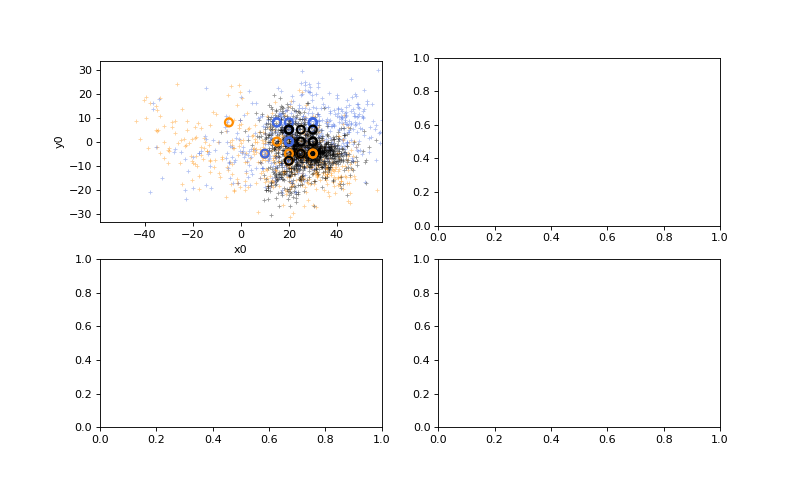

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]